Using device: cuda
Dataset sizes - Train: 64, Val: 8, Test: 8


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 200MB/s]  


Starting training...
Epoch 1/35 | Train Loss: 1.2257 | Val Accuracy: 0.1250 | MAE: 8.62
Epoch 2/35 | Train Loss: 0.6129 | Val Accuracy: 0.1250 | MAE: 7.00
Epoch 3/35 | Train Loss: 0.4631 | Val Accuracy: 0.2500 | MAE: 5.50
Epoch 4/35 | Train Loss: 0.4120 | Val Accuracy: 0.2500 | MAE: 6.50
Epoch 5/35 | Train Loss: 0.3565 | Val Accuracy: 0.2500 | MAE: 6.38
Epoch 6/35 | Train Loss: 0.3447 | Val Accuracy: 0.2500 | MAE: 4.88
Epoch 7/35 | Train Loss: 0.3232 | Val Accuracy: 0.2500 | MAE: 4.88
Epoch 8/35 | Train Loss: 0.3269 | Val Accuracy: 0.2500 | MAE: 5.00
Epoch 9/35 | Train Loss: 0.2929 | Val Accuracy: 0.2500 | MAE: 5.62
Epoch 10/35 | Train Loss: 0.2589 | Val Accuracy: 0.2500 | MAE: 5.00
Epoch 11/35 | Train Loss: 0.2620 | Val Accuracy: 0.2500 | MAE: 4.25
Epoch 12/35 | Train Loss: 0.2526 | Val Accuracy: 0.2500 | MAE: 4.50
Epoch 13/35 | Train Loss: 0.2455 | Val Accuracy: 0.1250 | MAE: 4.88
Epoch 14/35 | Train Loss: 0.2292 | Val Accuracy: 0.1250 | MAE: 4.88
Epoch 15/35 | Train Loss: 0.2312 | V

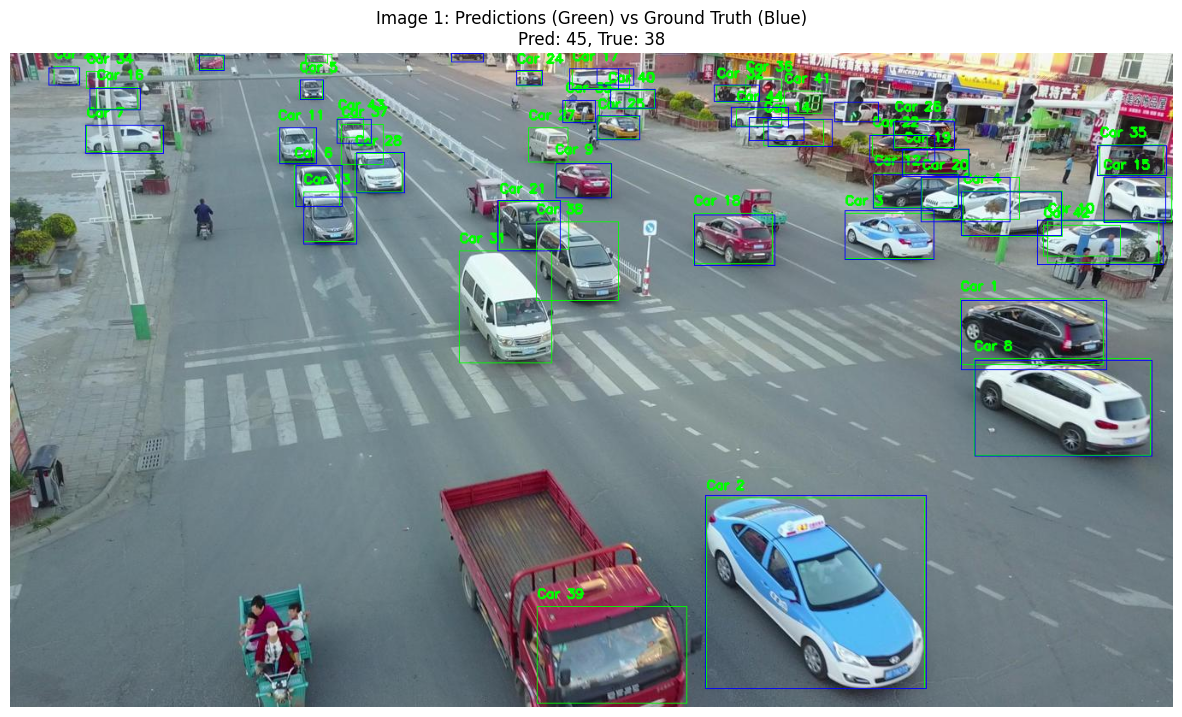


Image 2/7: 0000271_00201_d_0000375.jpg
Predicted cars: 20
True cars: 18
Error: 2


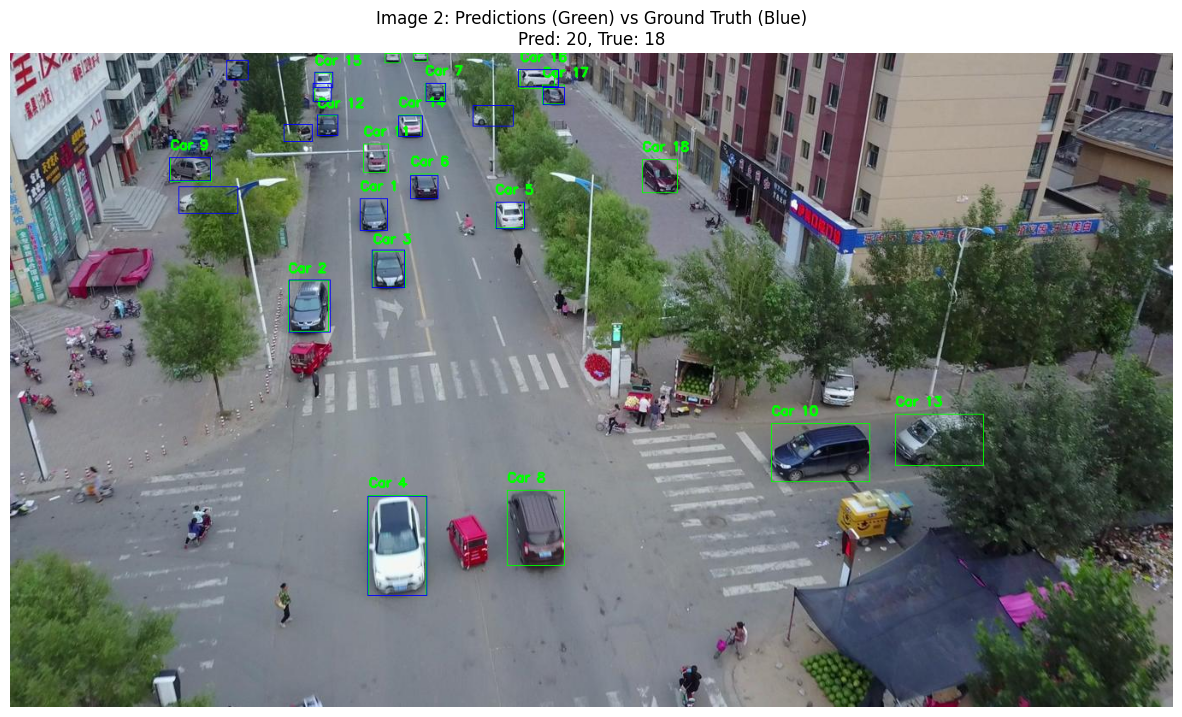


Image 3/7: 0000312_01201_d_0000420.jpg
Predicted cars: 31
True cars: 32
Error: 1


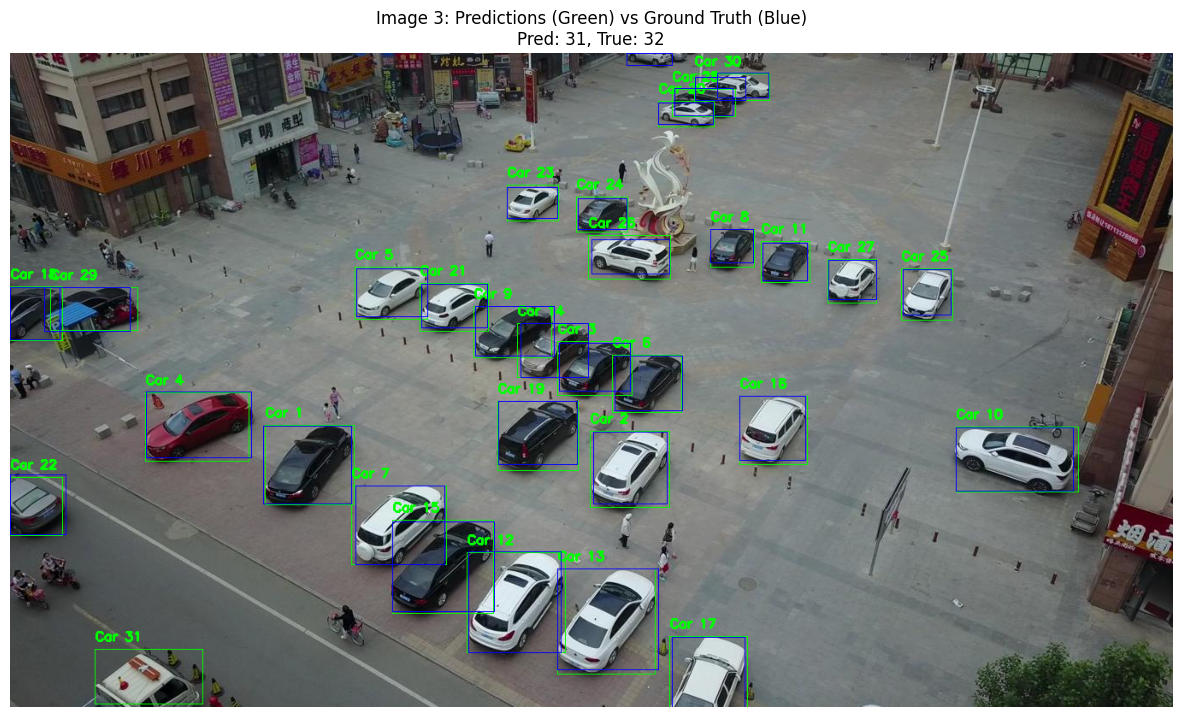


Image 4/7: 0000316_01401_d_0000526.jpg
Predicted cars: 10
True cars: 10
Error: 0


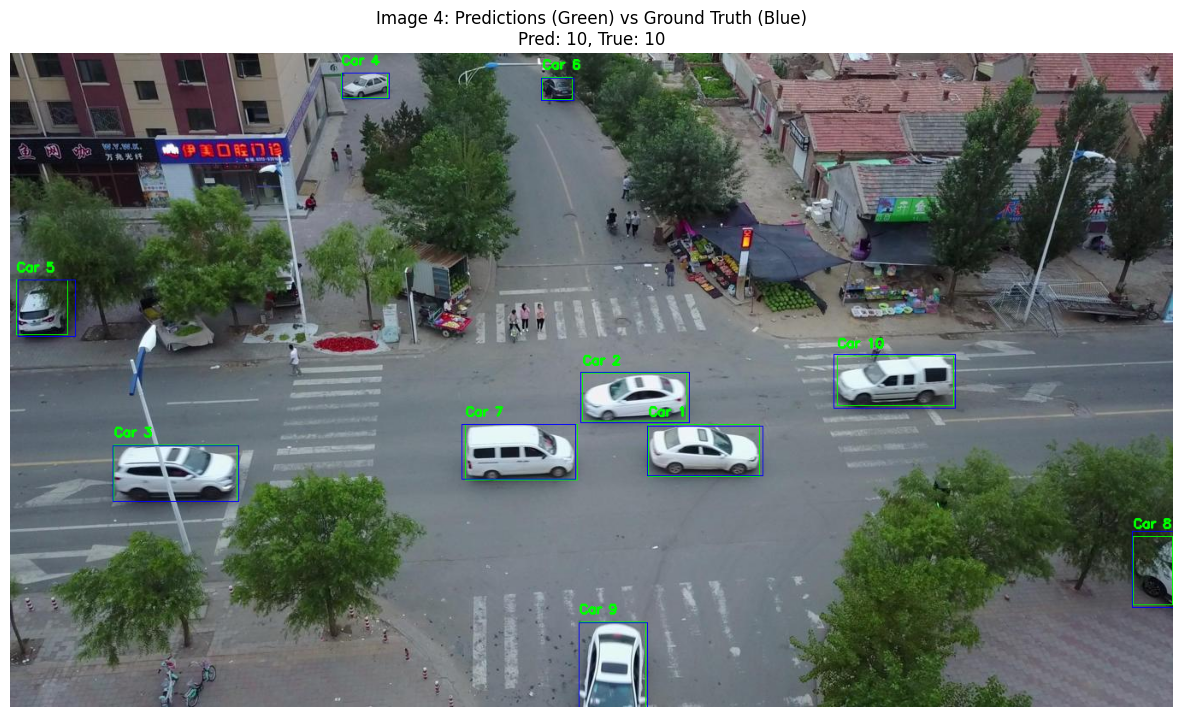


Image 5/7: 0000117_01731_d_0000089.jpg
Predicted cars: 15
True cars: 16
Error: 1


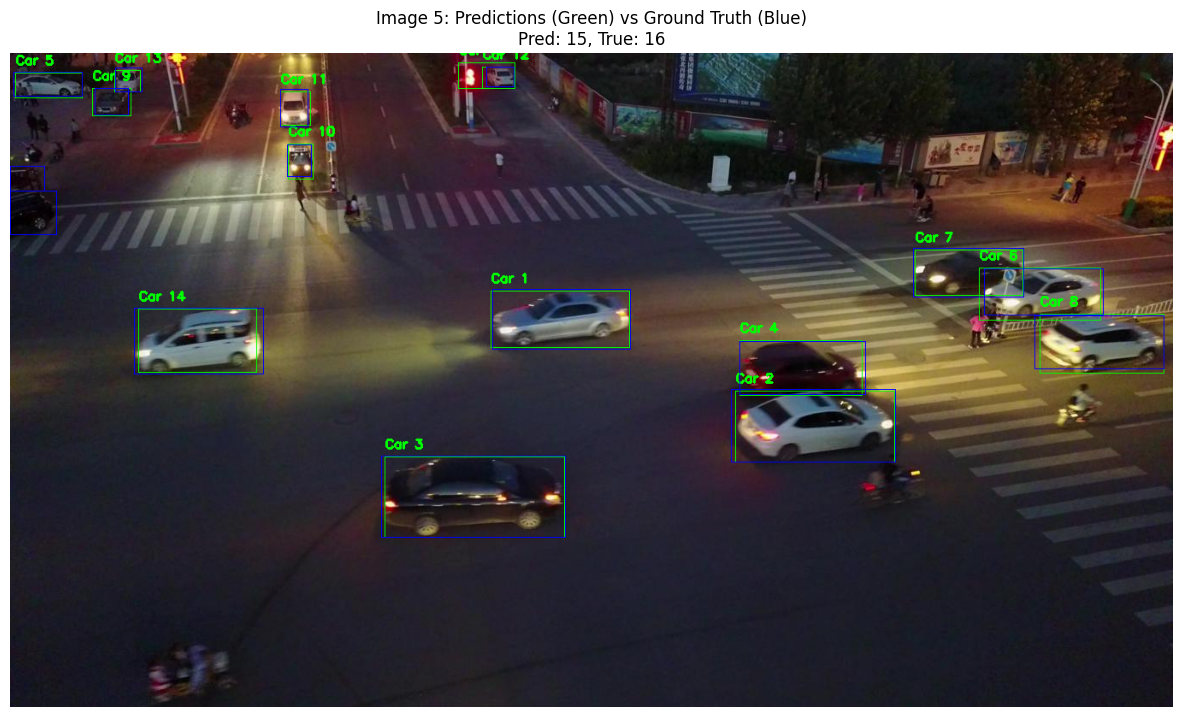


Image 6/7: 0000330_04001_d_0000820.jpg
Predicted cars: 10
True cars: 7
Error: 3


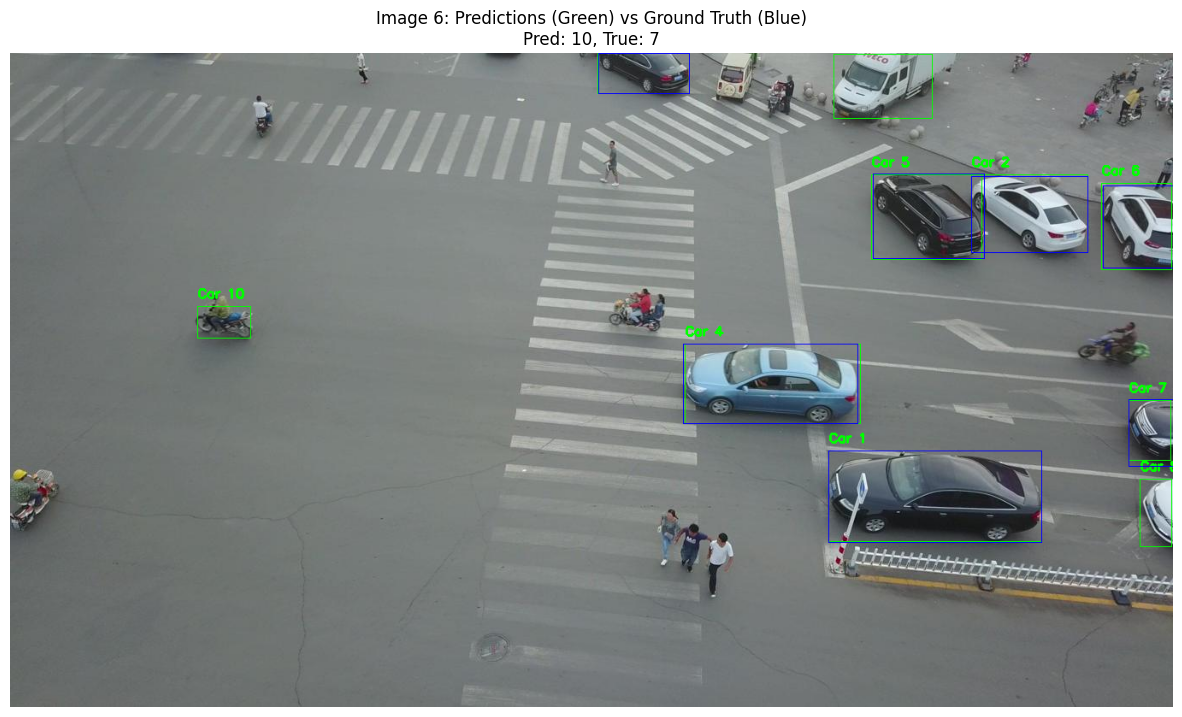


Image 7/7: 0000024_01543_d_0000015.jpg
Predicted cars: 0
True cars: 0
Error: 0


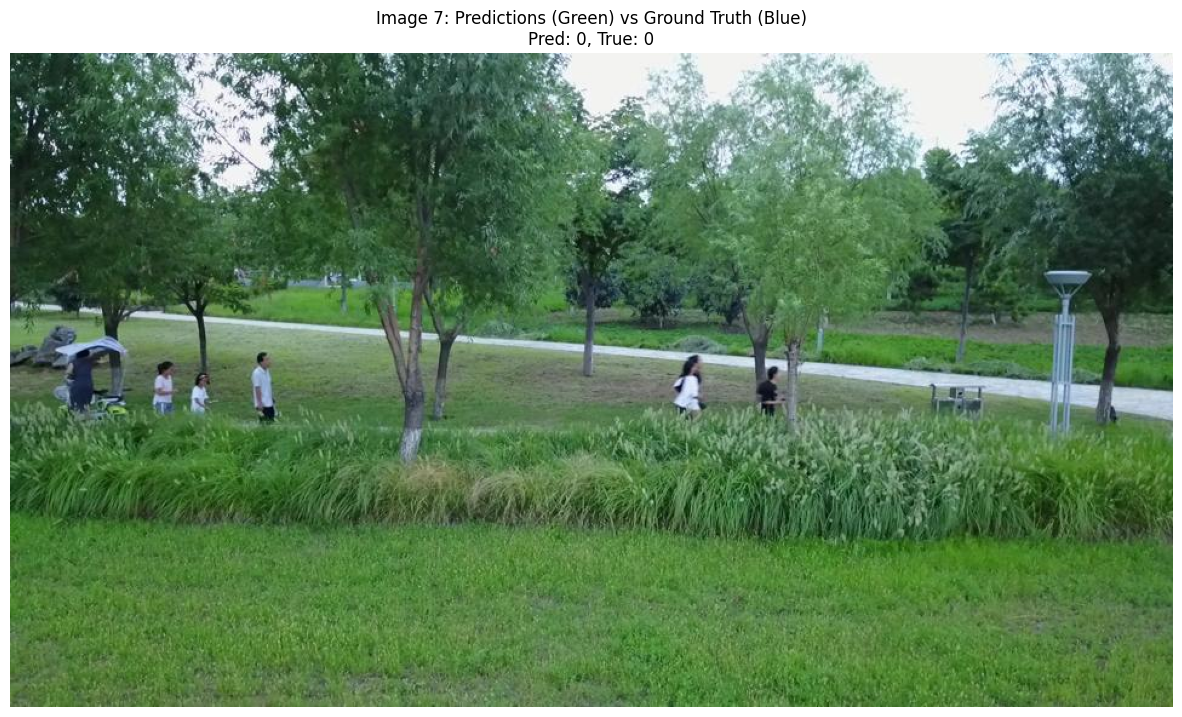


Test MAE: 2.00


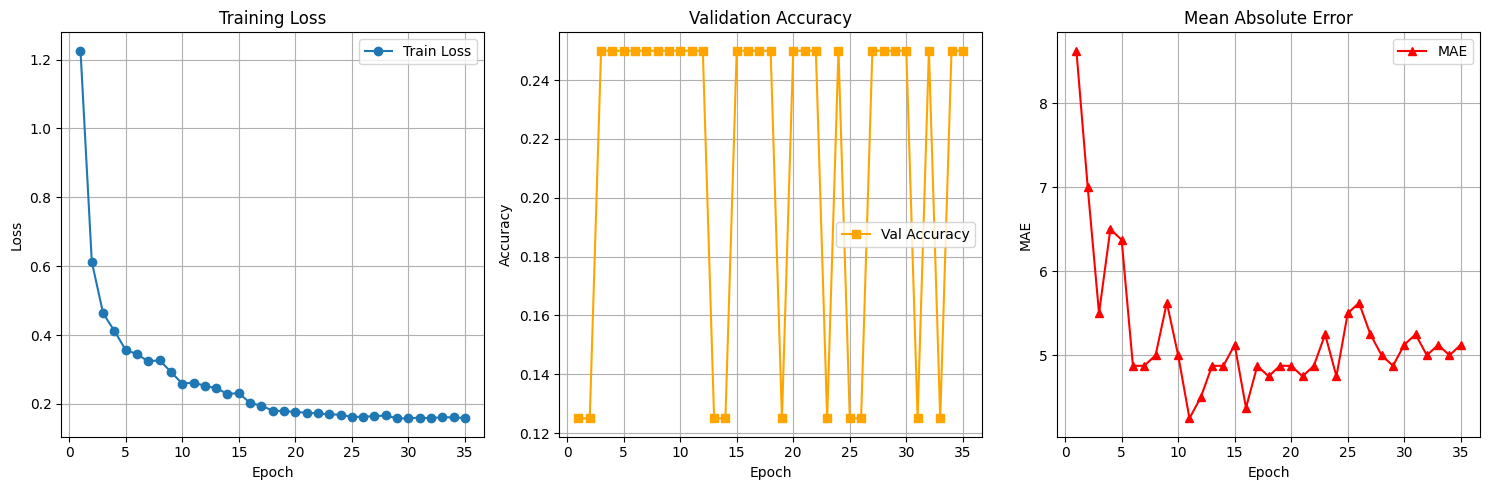

In [1]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from torchvision import transforms

class VisDroneDataset(Dataset):
    def __init__(self, images_path, annotations_path, augment=False):
        self.images_path = images_path
        self.annotations_path = annotations_path
        self.augment = augment
        self.image_files = sorted([f for f in os.listdir(images_path) if f.endswith(".jpg")])
        
        if augment:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                transforms.ToTensor(),
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
            ])

    def __len__(self):
        return len(self.image_files)

    def has_cars(self, ann_path):
        if not os.path.exists(ann_path):
            return False
        with open(ann_path, 'r') as f:
            for line in f:
                try:
                    data = list(map(float, line.strip().split(',')))
                    if len(data) >= 6 and data[5] == 4:
                        return True
                except ValueError:
                    continue
        return False

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_path, self.image_files[idx])
        ann_path = os.path.join(self.annotations_path, self.image_files[idx].replace(".jpg", ".txt"))
        image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        original_height, original_width = image.shape[:2]
        boxes = []
        labels = []
        
        if os.path.exists(ann_path):
            with open(ann_path, 'r') as f:
                for line in f:
                    try:
                        data = list(map(float, line.strip().split(',')))
                        if len(data) >= 6:
                            x, y, w, h, _, category = data[:6]
                            if category == 4 and w > 5 and h > 5:
                                x = max(0, min(x, original_width - 1))
                                y = max(0, min(y, original_height - 1))
                                w = min(w, original_width - x)
                                h = min(h, original_height - y)
                                
                                if w > 0 and h > 0:
                                    boxes.append([x, y, x+w, y+h])
                                    labels.append(1)
                    except (ValueError, IndexError):
                        continue

        if len(boxes) == 0:
            boxes.append([0.0, 0.0, 1.0, 1.0])
            labels.append(0)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        valid_boxes = []
        valid_labels = []
        for i, box in enumerate(boxes):
            if box[2].item() > box[0].item() and box[3].item() > box[1].item():  # width > 0 and height > 0
                valid_boxes.append(box.tolist())
                valid_labels.append(labels[i].item())
        
        if len(valid_boxes) == 0:
            valid_boxes = [[0.0, 0.0, 1.0, 1.0]]
            valid_labels = [0]
            
        boxes = torch.as_tensor(valid_boxes, dtype=torch.float32)
        labels = torch.as_tensor(valid_labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
        }

        if self.transform:
            image = self.transform(image)

        return image, target

def get_model(num_classes):
    weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=weights)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

def collate_fn(batch):
    return tuple(zip(*batch))

def train(model, dataloader, val_dataloader, device, num_epochs=5, confidence_threshold=0.5):
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.0005)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 25], gamma=0.1)
    train_losses = []
    val_accuracies = []
    mae_list = []
    min_train_loss = 1000

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        num_batches = 0
        
        for images, targets in dataloader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            valid_images = []
            valid_targets = []
            for img, target in zip(images, targets):
                if len(target['boxes']) > 0:
                    valid_images.append(img)
                    valid_targets.append(target)
            
            if len(valid_images) == 0:
                continue
                
            loss_dict = model(valid_images, valid_targets)
            losses = sum(loss for loss in loss_dict.values())
            optimizer.zero_grad()
            losses.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += losses.item()
            num_batches += 1

        if num_batches > 0:
            train_loss = total_loss / num_batches
            train_losses.append(train_loss)
        else:
            train_losses.append(0.0)

        model.eval()
        correct = 0
        total = 0
        mae_errors = []
        
        with torch.no_grad():
            for images, targets in val_dataloader:
                images = list(image.to(device) for image in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                predictions = model(images)
                
                for pred, target in zip(predictions, targets):
                    true_car_count = (target['labels'] == 1).sum().item()

                    confident_preds = pred['scores'] > confidence_threshold
                    pred_car_count = confident_preds.sum().item()
                    
                    if pred_car_count == true_car_count:
                        correct += 1
                    total += 1

                    mae_errors.append(abs(pred_car_count - true_car_count))
        
        val_accuracy = correct / total if total > 0 else 0
        mae = sum(mae_errors) / len(mae_errors) if mae_errors else 0
        
        val_accuracies.append(val_accuracy)
        mae_list.append(mae)
        
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Accuracy: {val_accuracy:.4f} | MAE: {mae:.2f}")

        scheduler.step()

        if train_loss < min_train_loss:
            min_train_loss = train_loss
            torch.save(model.state_dict(), 'best_car_counter.pth')

    return {'train_losses': train_losses, 'val_accuracies': val_accuracies, 'mae_list': mae_list}

def visualize_results(model, dataset, device, history, num_images=3, confidence_threshold=0.5):
    model.eval()
    print(f"Dataset size: {len(dataset)}")
    indices = np.random.choice(len(dataset), min(num_images, len(dataset)), replace=False)
    errors = []

    for i, idx in enumerate(indices):
        image, target = dataset[idx]

        with torch.no_grad():
            prediction = model([image.to(device)])[0]

        true_car_count = (target['labels'] == 1).sum().item()
        confident_preds = prediction['scores'] > confidence_threshold
        pred_car_count = confident_preds.sum().item()

        original_dataset = dataset.dataset if hasattr(dataset, 'dataset') else dataset
        if hasattr(dataset, 'indices'):
            real_idx = dataset.indices[idx]
            image_file = original_dataset.image_files[real_idx]
        else:
            image_file = original_dataset.image_files[idx]

        print(f"\nImage {i+1}/{num_images}: {image_file}")
        print(f"Predicted cars: {pred_car_count}")
        print(f"True cars: {true_car_count}")
        print(f"Error: {abs(pred_car_count - true_car_count)}")

        errors.append(abs(pred_car_count - true_car_count))

        if image.shape[0] == 3:
            image_vis = image.permute(1, 2, 0).cpu().numpy()
            if image_vis.max() <= 1.0:
                image_vis = (image_vis * 255).astype(np.uint8)
            else:
                image_vis = image_vis.astype(np.uint8)
        else:
            image_vis = image.cpu().numpy().astype(np.uint8)
        
        image_vis = np.ascontiguousarray(image_vis)
        
        if len(image_vis.shape) == 3 and image_vis.shape[2] == 3:
            image_vis = cv2.cvtColor(image_vis, cv2.COLOR_RGB2BGR)

        pred_boxes = prediction['boxes'][confident_preds].cpu().numpy()
        pred_scores = prediction['scores'][confident_preds].cpu().numpy()
        
        for idx_box, (box, score) in enumerate(zip(pred_boxes, pred_scores), start=1):
            box = box.astype(int)
            cv2.rectangle(image_vis, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 1)
            cv2.putText(image_vis, f'Car {idx_box}', (box[0], box[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        true_car_mask = target['labels'] == 1
        if true_car_mask.any():
            true_car_boxes = target['boxes'][true_car_mask]
            for box in true_car_boxes:
                box = box.cpu().numpy().astype(int)
                cv2.rectangle(image_vis, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 1)

        plt.figure(figsize=(15, 10))
        if len(image_vis.shape) == 3 and image_vis.shape[2] == 3:
            display_image = cv2.cvtColor(image_vis, cv2.COLOR_BGR2RGB)
        else:
            display_image = image_vis
        plt.imshow(display_image)
        plt.axis('off')
        plt.title(f'Image {i+1}: Predictions (Green) vs Ground Truth (Blue)\nPred: {pred_car_count}, True: {true_car_count}')
        plt.show()

    mae = sum(errors) / len(errors) if errors else 0
    print(f"\nTest MAE: {mae:.2f}")

    epochs = range(1, len(history['train_losses']) + 1)

    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_losses'], label='Train Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Loss')
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['val_accuracies'], label='Val Accuracy', marker='s', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Validation Accuracy')
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(epochs, history['mae_list'], label='MAE', marker='^', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.title('Mean Absolute Error')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    train_dataset_full = VisDroneDataset(
        images_path="/kaggle/input/visdrone5/VisDrone2029-DET-val5/images",
        annotations_path="/kaggle/input/visdrone5/VisDrone2029-DET-val5/annotations",
        augment=True
    )
    
    val_test_dataset = VisDroneDataset(
        images_path="/kaggle/input/visdrone5/VisDrone2029-DET-val5/images",
        annotations_path="/kaggle/input/visdrone5/VisDrone2029-DET-val5/annotations",
        augment=False
    )

    total_size = len(train_dataset_full)
    train_size = int(0.8 * total_size)
    val_size = int(0.1 * total_size)
    test_size = total_size - train_size - val_size
    
    print(f"Dataset sizes - Train: {train_size}, Val: {val_size}, Test: {test_size}")
    
    indices = torch.randperm(total_size).tolist()
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]
    
    train_dataset = torch.utils.data.Subset(train_dataset_full, train_indices)
    val_dataset = torch.utils.data.Subset(val_test_dataset, val_indices)
    test_dataset = torch.utils.data.Subset(val_test_dataset, test_indices)

    train_dataloader = DataLoader(
        train_dataset,
        batch_size=4,
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=2
    )
    val_dataloader = DataLoader(
        val_dataset,
        batch_size=4,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=2
    )

    model = get_model(num_classes=2)
    model.to(device)

    if not os.path.exists('best_car_counter.pth'):
        print("Starting training...")
        history = train(model, train_dataloader, val_dataloader, device, num_epochs=35, confidence_threshold=0.5)
    else:
        print("Loading pre-trained model...")
        model.load_state_dict(torch.load('best_car_counter.pth', map_location=device))

    visualize_results(model, test_dataset, device, history, num_images=7, confidence_threshold=0.5)